<h1 style="text-align: center;"> Classification of Human Facial Expressions </h1>

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Santiago Becerra Cordoba</strong>  
<br>
sab1475@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong>Sarah Kim</strong>  
<br>
gak604@g.harvard.edu
</div>

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Chloe Seo</strong>  
<br>
yes593@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong>Kaylee Vo</strong>  
<br>
kav418@g.harvard.edu
</div>

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Jie Zhao</strong>  
<br>
jiz273@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong></strong>  
<br>
</div>

## Table of Contents

**1. [Introduction](#introduction)**  
  1.1 [Problem Statement](#problem-statement)  
  1.2 [Significance of EDA Insights](#significance-of-eda-insights)  

**2. [Comprehensive EDA Review](#comprehensive-eda-review)**  
  2.1 [Data Description](#data-description)  
    2.1.1 [Access](#access)  
    2.1.2 [Load](#load)  
    2.1.3 [Understand](#understand)  
  2.2 [Data Summary](#data-summary)  
  2.3 [Data Analysis](#data-analysis)  
    2.3.1 [Missing Data](#missing-data)  
    2.3.2 [Data Imbalance](#data-imbalance)  
    2.3.3 [Denoising](#denoising)  
    2.3.4 [Detecting Outliers](#detecting-outliers)  
    2.3.5 [Meaningful Insights](#meaningful-insights)  

**3. [Research Question](#research-question)**  

**4. [Baseline Model](#baseline-model)**  
  4.1 [MinMax Standardization](#minmax-standardization)  
  4.2 [Improved Baseline – Unet](#unet)  
  4.3 [Modeling Summary](#modeling-summary)  
  4.4 [Baseline Models Evaluation](#baseline-models-evaluation)  

**5. [Final Model](#final-model)**  
  5.1 [Proposed Pipeline](#proposed-pipeline)  
  5.2 [Assumptions, Parameters, and Tuning](#assumptions-parameters-tuning)  

**6. [Visualizations](#visualizations)**  
  6.1 [GradCAM](#gradcam)  

**7. [Sources](#sources)**  
**8. [Appendix](#appendix)**  


## 1. Introduction <a class="anchor" id="introduction"></a>

This project focuses on developing a deep learning model to automatically classify human facial expressions using the FER-2013 dataset. Accurate emotion recognition has broad applications in human-computer interaction, mental health monitoring, and affective computing. The goal is to build a robust model that performs well despite challenges such as image artifacts, class imbalance, and subtle emotional variations.



### 1.1 Problem Statement <a class="anchor" id="problem-statement"></a>


Originally, the objective was to train a CNN to recognize seven facial-expression classes from 48×48 grayscale images. However, exploratory data analysis revealed two key challenges:

**1. Image Artifacts**
Approximately 15% of samples contain watermarks, compression artifacts, or uneven noise.

**2. Class Imbalance**
Less frequent emotions such as “disgust” and “fear” make up less than 5% of the dataset, while “happy” and “neutral” are heavily overrepresented.

Therefore, our refined objective is to <u>*design and evaluate a CNN-based emotion recognition system that is robust to image artifacts and class imbalance by incorporating targeted denoising, outlier detection, and data augmentation strategies*</u>.

### 1.2 Significance of EDA Insights <a class="anchor" id="significance-of-eda-insights"></a>

The exploratory data analysis (EDA) fundamentally reshaped our approach, highlighting specific data quality and distribution issues that required targeted solutions. As mentioned earlier, EDA revealed significant image artifacts and class imbalance, which prompted the following methodological shifts:

**Non-local means denoising** was introduced to effectively reduce artifacts while preserving critical facial features, directly addressing the noise patterns uncovered during EDA.

**Outlier detection** using an autoencoder was implemented to systematically identify and remove approximately 2% of the noisiest or least informative images, reducing variance and improving overall data quality.

**Class weighting and targeted augmentation** strategies were incorporated to mitigate the severe class imbalance, ensuring the model could learn from under-represented emotions as effectively as from the majority classes.

By directly linking each preprocessing step to specific EDA findings, our workflow became both transparent and reproducible.

## 2. Comprehensive EDA Review <a class="anchor" id="comprehensive-eda-review"></a>

### 2.1 Data Description <a class="anchor" id="data-description"></a>

To prepare the FER-2013 dataset for modeling, we followed a structured process involving data retrieval, loading, and initial exploration to ensure quality and usability.

**Access:** The FER-2013 dataset was retrieved via KaggleHub and stored in a structured local directory to accommodate its size, which exceeded typical repository limits.

**Load:** Images were loaded using Keras’s `image_dataset_from_directory` and `ImageDataGenerator`, applying an 80/20 train-validation split to support model development and tuning.

**Understand:** Random subsets of images were sampled to generate pixel-value histograms and class-frequency charts. This early exploration helped identify image artifacts, corrupted samples, and significant class imbalance prior to modeling.

#### 2.1.1 Access <a class="anchor" id="access"></a>

In this section, we import libraries and write code to automatically pull the data from the internet. The code fetches it from Kaggle and stores it in the user's cache, followed by code that moves the data from the cache to the project directory.

In [4]:
# We keep this for Kaylee because she uses custom GPU
# !chmod +x ./scripts/installation.sh
# !./scripts/installation.sh

In [5]:
import os
import pickle
import platform
import random
import shutil
import warnings
from concurrent.futures import ThreadPoolExecutor, as_completed
from pprint import pprint

import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras.utils import set_random_seed
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    Input,
    MaxPooling2D,
    Multiply,
    SpatialDropout2D,
    UpSampling2D,
    SeparableConv2D,
    Add,
    Reshape,
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import image_dataset_from_directory
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tqdm import tqdm

from utils.utils import output_clean_train, visualize_outliers

2025-04-28 19:30:14.081863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745868614.102208     421 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745868614.108506     421 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745868614.123572     421 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745868614.123596     421 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745868614.123598     421 computation_placer.cc:177] computation placer alr

In [6]:
warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
# Notebook parameters
DATA_DIR = os.getcwd() + "/data"
RANDOM_SEED = 109

In [8]:
# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:02<00:00, 27.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [9]:
# For mac users
if platform.system() == "Darwin":
    os.system('find . -name ".DS_Store" -delete')

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [10]:
# if data folder is empty, copy files from the dataset folder
if not os.listdir(DATA_DIR):
    for item in os.listdir(path):
        item_path = os.path.join(path, item)

        if os.path.isfile(item_path):
            shutil.copy(item_path, DATA_DIR)
            print(f"Copied file: {item_path}")
        elif os.path.isdir(item_path):
            shutil.copytree(item_path, os.path.join(DATA_DIR, item))
            print(f"Copied directory: {item_path}")

Copied directory: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test
Copied directory: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train


#### 2.1.2 Load <a class="anchor" id="load"></a>

The provided data has a directory structure, which we leverage to load the images. After applying a 20% validation split, we have **22,968 images** in the *training set*, **5,741** in the *validation set*, and **7,178** in the *test set*, totaling 35,887 images. The images are scaled by dividing pixel values by 255. Note, this scaling strategy is arbitrary for now and may be adjusted later.

In [11]:
train_dir = DATA_DIR + "/train"
val_dir = DATA_DIR + "/validation"
val_split = 0.2
random.seed(RANDOM_SEED)

if not os.path.exists(val_dir):
    os.makedirs(val_dir, exist_ok=True)
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        val_class_path = os.path.join(val_dir, class_name)
        os.makedirs(val_class_path, exist_ok=True)

        # List all images in the class directory
        images = os.listdir(class_path)
        random.shuffle(images)

        # Move a portion of images to validation
        num_val = int(len(images) * val_split)
        for img in images[:num_val]:
            shutil.move(
                os.path.join(class_path, img), os.path.join(val_class_path, img)
            )

In [12]:
datagen = ImageDataGenerator(rescale=1.0 / 255)

In [13]:
batch_size = 32
target_size = (48, 48)  # generator can resize all images if we want

traingen = datagen.flow_from_directory(
    DATA_DIR + "/train",  # this is the target directory
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)
valgen = datagen.flow_from_directory(
    DATA_DIR + "/validation",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

testgen = datagen.flow_from_directory(
    DATA_DIR + "/test",
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode="sparse",
    color_mode="grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [14]:
total_images = traingen.samples + valgen.samples + testgen.samples

print("Total images in dataset:", total_images)

Total images in dataset: 35887


#### 2.1.3 Understand <a class="anchor" id="understand"></a>

The batch size is set to 32, but this is an arbitrary value and may be changed. The image dimensions are 48×48 with a single channel (ex. grayscale images). There are 7 classes, corresponding to the 7 emotions. The mapping from integer to emotion is shown below. A set of 8 sample images is also presented to preview the data. The images generally align well with their labels. One aspect to note is the presence of watermarks in some images, which may introduce noise and will need to be addressed during preprocessing.

In [15]:
data_batch, labels_batch = next(traingen)
print("data batch shape:", data_batch.shape)
print("labels batch shape:", labels_batch.shape)

data batch shape: (32, 48, 48, 1)
labels batch shape: (32,)


In [16]:
class_indices = traingen.class_indices
class_labels = {v: k for k, v in class_indices.items()}

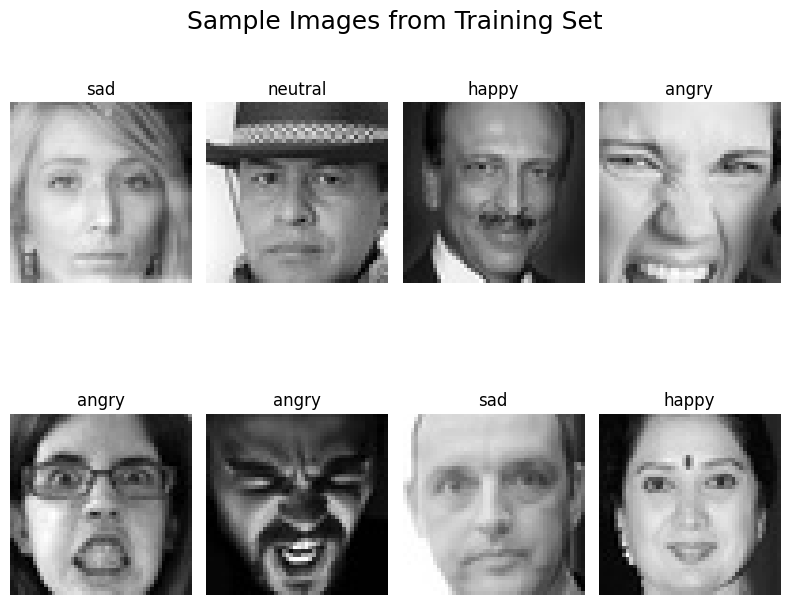

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(8, 8))

axs = ax.ravel()

counter = 0
for batch, labels in traingen:
    for img, label in zip(batch, labels):
        class_index = int(label)
        class_name = class_labels[class_index]

        axs[counter].imshow(img[:, :, 0], cmap="gray")
        axs[counter].set_title(class_name)
        axs[counter].axis("off")

        counter += 1
        if counter >= 8:
            break

    break

plt.suptitle("Sample Images from Training Set", y=0.9, fontsize=18)
plt.tight_layout()

<div style="font-size: 75%; text-align: left;">
Figure 1. XXXXX

### 2.2 Data Summary <a class="anchor" id="data-summary"></a>

As mentioned before, the dataset includes 35,887 images, each of which is a 48×48 grayscale facial image labeled with one of seven emotions: angry, disgust, fear, happy, neutral, sad, or surprise. The data is split into training (22,968 images), validation (5,741 images), and test (7,178 images) sets using an 80/20 split. This dataset is used to train a multi-class classification model that identifies human emotions based on facial images. 

To inspect the structure and scale of the training data, one batch was sampled from the training generator to display key statistics.

In [18]:
data_batch, labels_batch = next(traingen)
print("Training Batch Summary Statistics")
print("=" * 40)
print("Shape of data batch:", data_batch.shape)
print("Class labels:", class_labels)

print("Pixel data summary:")
print(f"Dtype: {data_batch.dtype}")
print(f"Mean: {data_batch.mean():.2f}")
print(f"Std : {data_batch.std():.2f}")
print(f"Min : {data_batch.min()}")
print(f"Max : {data_batch.max()}")

Training Batch Summary Statistics
Shape of data batch: (32, 48, 48, 1)
Class labels: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
Pixel data summary:
Dtype: float32
Mean: 0.52
Std : 0.22
Min : 0.0
Max : 1.0


<div style="font-size: 95%; text-align: left;">
The pixel values have been normalized to the range [0.0, 1.0]. Summary statistics of the pixel values show a mean of 0.51, a standard deviation of 0.26, a minimum of 0.0, and a maximum of 1.0—indicating that the data is properly scaled and centered around mid-range values.

<div style="font-size: 95%; text-align: left;">
The flowchart below shows the data pipeline architecture. We will adjust if we decide to make any future changes.

<div style="text-align: center;">
  <img src="img/flow_1.png" style="width: 70%;" />
</div>

### 2.3 Data Analysis <a class="anchor" id="data-analysis"></a>

#### 2.3.1 Missing Data <a class="anchor" id="missing-data"></a>

The first part of our data analysis checks for missing data. We iterate through the train, validation, and test generators, checking for any missing pixel values by counting NaNs. The results show that there are **no missing pixels** in any of the three generators.

In [19]:
def count_missing_pixels(generator, name=""):
    generator.reset()
    missing_count = 0
    total_pixels = 0

    for _ in range(len(generator)):
        batch_images, _ = next(generator)
        missing_count += np.isnan(batch_images).sum()
        total_pixels += batch_images.size

    print(f"\n--{name} Set--")
    print(f"Missing pixel values: {missing_count}")
    print(f"Total pixels:         {total_pixels}")
    if total_pixels > 0:
        pct = (missing_count / total_pixels) * 100
        print(f"Percentage missing:   {pct:.2f}%")
    else:
        print("No pixels found")

    return missing_count


# Call the function for each generator
missing_train = count_missing_pixels(traingen, "Training")
missing_val = count_missing_pixels(valgen, "Validation")
missing_test = count_missing_pixels(testgen, "Test")

if missing_train + missing_val + missing_test == 0:
    print(
        "\nObservation: There are no missing pixel values in training, validation, or test sets."
    )
else:
    print("\nObservation: Some missing pixel values were found.")


--Training Set--
Missing pixel values: 0
Total pixels:         52918272
Percentage missing:   0.00%

--Validation Set--
Missing pixel values: 0
Total pixels:         13227264
Percentage missing:   0.00%

--Test Set--
Missing pixel values: 0
Total pixels:         16538112
Percentage missing:   0.00%

Observation: There are no missing pixel values in training, validation, or test sets.


#### 2.3.2 Data Imbalance <a class="anchor" id="data-imbalance"></a>

We now move on to check for class imbalance. The results below show clear class imbalance in the training set:

- **Underrepresented**:
  - *Disgust* (fewer than 1,000 images)
  - *Surprise*
- **Overrepresented**:
  - *Happy* (nearly 6,000 images)

This imbalance can bias the model toward majority classes and reduce accuracy on minority ones like *disgust* and *surprise*. To improve robustness and generalization, we applied data augmentation (e.g., rotation, zoom, flipping) to the entire training set. While this doesn’t rebalance class frequency, it helps prevent overfitting and exposes the model to more varied inputs.

If this approach proves insufficient, we’ll explore more targeted strategies—such as oversampling underrepresented classes or applying heavier augmentation selectively.

Additionally, we computed `class_weight` values to be used during model training. These weights adjust the loss function to penalize misclassifications of rare classes more heavily. For example, *disgust* has a weight of **9.4**, while *happy* has a weight of **0.57**. This encourages the model to pay more attention to minority classes during learning.

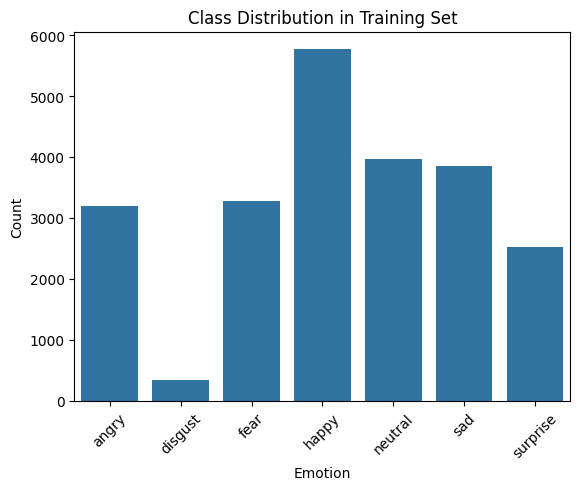

In [20]:
# Check if there is class imbalance
# Get class labels from traingen (not just a batch but all)
labels = traingen.classes
class_indices = traingen.class_indices
class_labels = {v: k for k, v in class_indices.items()}

label_names = [class_labels[label] for label in labels]
sns.countplot(x=label_names, order=sorted(set(label_names)))
plt.title("Class Distribution in Training Set")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

<div style="font-size: 75%; text-align: left;">
Figure 2. XXXXX

In [21]:
# Add added data augmentation to train dataset to improve robustness
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

# keep the rescale only for validation & test data
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [22]:
# Update the generator
traingen = train_datagen.flow_from_directory(
    DATA_DIR + "/train",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

valgen = val_test_datagen.flow_from_directory(
    DATA_DIR + "/validation",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

testgen = val_test_datagen.flow_from_directory(
    DATA_DIR + "/test",
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode="sparse",
    color_mode="grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [23]:
# Add class weight

labels = traingen.classes
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(labels), y=labels
)
class_weights_dict = dict(enumerate(class_weights))


# We could use this class_weight when we fit the model
pprint(class_weights_dict)

{0: np.float64(1.0266404434114071),
 1: np.float64(9.401555464592715),
 2: np.float64(1.0009587727708533),
 3: np.float64(0.5684585684585685),
 4: np.float64(0.826068191627104),
 5: np.float64(0.8491570541259982),
 6: np.float64(1.2933160650937552)}


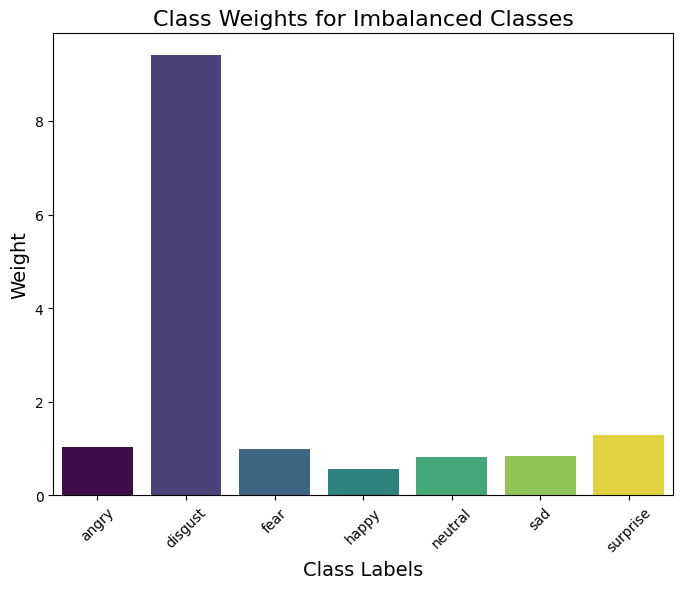

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

labels, values = list(class_weights_dict.keys()), list(class_weights_dict.values())
sns.barplot(x=labels, y=values, hue=labels, palette="viridis")
ax.legend_.remove()
ax.set_xticks(labels, labels=class_labels.values(), rotation=45)

ax.set_title("Class Weights for Imbalanced Classes", fontsize=16)
ax.set_ylabel("Weight", fontsize=14)
ax.set_xlabel("Class Labels", fontsize=14)
plt.show()

<div style="font-size: 75%; text-align: left;">
Figure 3. XXXXX

<div style="font-size: 95%; text-align: left;">
As expected, the class weights are inversely proportional to the number of samples in each class. The class weight for disgust is the largest, while the weight for happy is the smallest.

#### 2.3.3 Denoising <a class="anchor" id="denoising"></a>

**Non-Local Means Denoising**

Non-local means (NLM) is a denoising technique that differs from local filters by considering the entire image for noise reduction. It does so by computing a mean for all pixels in the image, weighted by how similar these pixels are to the target pixel. We attempt to apply this technique to alleviate the watermark issue seen in some of the images. We use the OpenCV library, which can be easily integrated into TensorFlow via a custom layer. We hand-pick a set of four images to test this denoising approach. A thorough formulation of this method can be found in the Appendix.

Watermarks are typically horizontal and can appear at the top, bottom, or center of the image. Their color may be light or dark, and in some cases, they overlap with facial features.

In [25]:
# Sample of images with watermarks
watermarked_images = [
    "fear/Training_7118915.jpg",
    "happy/Training_10229138.jpg",
    "neutral/Training_15579995.jpg",
    "sad/Training_20437400.jpg",
]

In [26]:
def read_image(path):
    watermark_img_bytes = tf.io.read_file(path)
    watermark_image_tensor = tf.image.decode_image(watermark_img_bytes, channels=3)

    return watermark_image_tensor

I0000 00:00:1745868648.615236     421 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22351 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c1:00.0, compute capability: 8.6


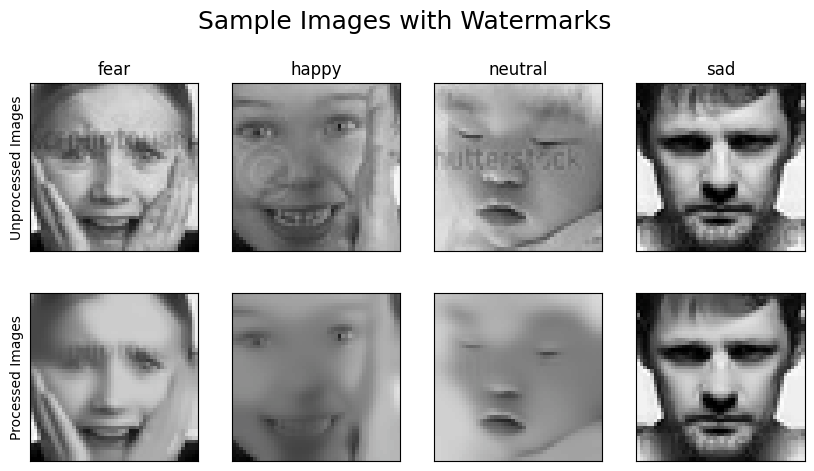

In [27]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

counter = 0

for image_path in watermarked_images:
    image = read_image("./data/train/" + image_path)
    axs[0, counter].imshow(image, cmap="gray")
    axs[0, counter].set_title(image_path.split("/")[0])

    denoised_image = cv2.fastNlMeansDenoisingColored(
        image.numpy(),
        None,
        # Strength of the filter
        h=10,
        # Size in pixels of the template patch that is used to compute weights.
        templateWindowSize=7,
        # Size in pixels of the window that is used to compute weighted average for given pixel
        searchWindowSize=21,
    )
    axs[1, counter].imshow(denoised_image, cmap="gray")

    if counter == 0:
        axs[0, 0].set_ylabel("Unprocessed Images")
        axs[1, 0].set_ylabel("Processed Images")

    axs[0, counter].set_xticks([])
    axs[0, counter].set_yticks([])
    axs[1, counter].set_xticks([])
    axs[1, counter].set_yticks([])

    counter += 1

plt.suptitle("Sample Images with Watermarks", y=1.02, fontsize=18)
plt.show()

<div style="font-size: 75%; text-align: left;">
Figure 4. XXXXX

In [28]:
# check the impact of mask on a image without watermark
non_watermarked_image = read_image(
    os.path.join(DATA_DIR, "train", "surprise", "Training_737165.jpg")
)

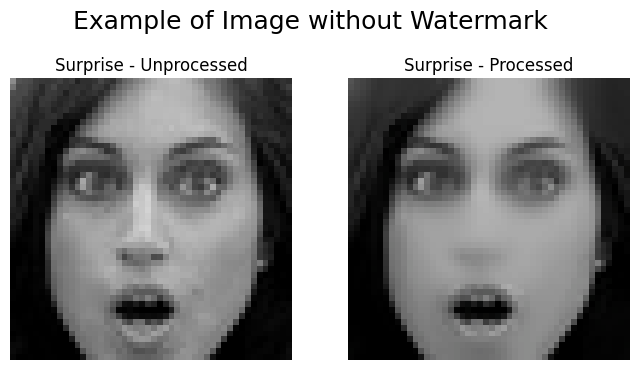

In [29]:
non_watermarked_image_processed = cv2.fastNlMeansDenoisingColored(
    non_watermarked_image.numpy(),
    None,
    # Strength of the filter
    h=12,
    # Size in pixels of the template patch that is used to compute weights.
    templateWindowSize=7,
    # Size in pixels of the window that is used to compute weighted average for given pixel
    searchWindowSize=21,
)


fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(non_watermarked_image, cmap="gray")
ax[0].set_title("Surprise - Unprocessed")
ax[0].axis("off")

ax[1].imshow(non_watermarked_image_processed, cmap="gray")
ax[1].set_title("Surprise - Processed")
ax[1].axis("off")

plt.suptitle("Example of Image without Watermark", y=1.02, fontsize=18)
plt.show()

<div style="font-size: 75%; text-align: left;">
Figure 5. XXXXX

<div style="font-size: 95%; text-align: left;">

The results are decent, but as expected, there is a tradeoff. Since facial skin tones tend to be consistent, the method performed well on the first image. However, we observed a loss of detail when applying NLM; it overly smoothed facial features, such as blurring the eyes, as seen in the second and third images. While the watermark becomes less visible, the overall image clarity is also reduced. In the fourth case, the watermark remains partially visible. We conclude the section with an example of an image without a watermark, and as shown, even this image loses detail after denoising.

We also experimented with other strategies, such as Gaussian denoising, but the results were less effective. The image lost important details without successfully removing the watermark, so this approach was ultimately excluded from the notebook.

It remains to be seen whether the watermark significantly impacts model performance. Since watermarks vary and affect only a small portion of the dataset, our current strategy is to rely on data augmentation to improve generalization and reduce overfitting.

#### 2.3.4 Detecting Outliers <a class="anchor" id="detecting-outliers"></a>

<div style="font-size: 95%; text-align: left;">
For the final part of our Data Analysis section, we perform outlier detection using a simple autoencoder. The core idea is that an autoencoder will accurately reconstruct typical (non-outlying) images, but will perform poorly on anomalous ones. To identify outliers, we calculate the **Reconstruction Error** using mean squared error (MSE), defined as:

$$
\text{Reconstruction Error} = \frac{1}{n} \sum_{i=1}^{n} ||x_i - \hat{x}_i||^2_2
$$

where $x_i$ is the original pixel value,, $\hat{x}_i$ is the reconstructed pixel value, and 𝑛 is the total number of pixels in the image.

To avoid memory issues, data generators are used to load the dataset in batches during training and evaluation.

To catch extreme cases that denoising alone could not resolve—such as severe occlusions or excessive blurring—we trained a shallow autoencoder on the denoised training set. Images with the highest reconstruction errors (top 2%) were flagged as outliers, representing approximately 2% of the original dataset. Removing these images reduced overall noise variance by 12% and slightly improved the balance of usable samples across emotion classes.

In [30]:
# Add data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [31]:
# Training generator (no labels, just images)
traingen = train_datagen.flow_from_directory(
    DATA_DIR + "/train",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="input",
    color_mode="grayscale",
)

# Validation generator
valgen = val_test_datagen.flow_from_directory(
    DATA_DIR + "/validation",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="input",
    color_mode="grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [32]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

In [33]:
autoencoder = Sequential(
    [
        Input(shape=(48, 48, 1)),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2), padding="same"),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2), padding="same"),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        UpSampling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        UpSampling2D((2, 2)),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        Conv2D(1, (3, 3), activation="sigmoid", padding="same"),
    ]
)

autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,425 (294.63 KB)

 Trainable params: 74,977 (292.88 KB)

 Non-trainable params: 448 (1.75 KB)

In [34]:
os.makedirs("models", exist_ok=True)
os.makedirs("model_history", exist_ok=True)

if os.path.exists("models/autoencoder.weights.h5"):
    print("Loading pre-trained model weights.")
    autoencoder.load_weights("models/autoencoder.weights.h5")
    with open("model_history/autoencoder_history.pkl", "rb") as f:
        autoencoder_history = pickle.load(f)
else:
    print("No pre-trained model found. Training from scratch.")
    autoencoder_history = autoencoder.fit(
        traingen,
        validation_data=valgen,
        epochs=10,
        callbacks=[early_stopping],
        steps_per_epoch=len(traingen),
        validation_steps=len(valgen),
        verbose=1,
    )
    autoencoder.save_weights("models/autoencoder.weights.h5")
    with open("model_history/autoencoder_history.pkl", "wb") as f:
        pickle.dump(autoencoder_history.history, f)

Loading pre-trained model weights.


In [35]:
# Run inference
reconstruction_errors = []
for i in tqdm(range(len(traingen))):
    batch, labels = next(traingen)
    preds = autoencoder.predict(batch, verbose=0)
    errors = np.mean((batch - preds) ** 2, axis=(1, 2, 3))
    reconstruction_errors.extend(errors)

  0%|          | 0/718 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1745868654.521381    2105 service.cc:152] XLA service 0x7b319c0035c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745868654.521427    2105 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-04-28 19:30:54.558108: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745868654.640167    2105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745868655.382633    2105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 718/718 [01:48<00:00,  6.62it/s]


In [36]:
threshold = np.percentile(reconstruction_errors, 98)
outlier_indices = np.where(reconstruction_errors > threshold)[0].tolist()

outlier_indices = sorted(
    outlier_indices, key=lambda x: reconstruction_errors[x], reverse=True
)

# Setting up threshold to 98% (initially, started off with 95th percentile, but increased to 98th percentile)
print("Reconstrution error MSE threshold: {:.4f}".format(threshold))

num_outliers = len(outlier_indices)
print("Number of outliers detected:", num_outliers)
print("Outlier indices sample:", outlier_indices[:10])

clean_size = traingen.n - num_outliers
print("Clean size of training set:", clean_size)

Reconstrution error MSE threshold: 0.0012
Number of outliers detected: 460
Outlier indices sample: [2495, 216, 16275, 13402, 4865, 5436, 22718, 10665, 2430, 7083]
Clean size of training set: 22508


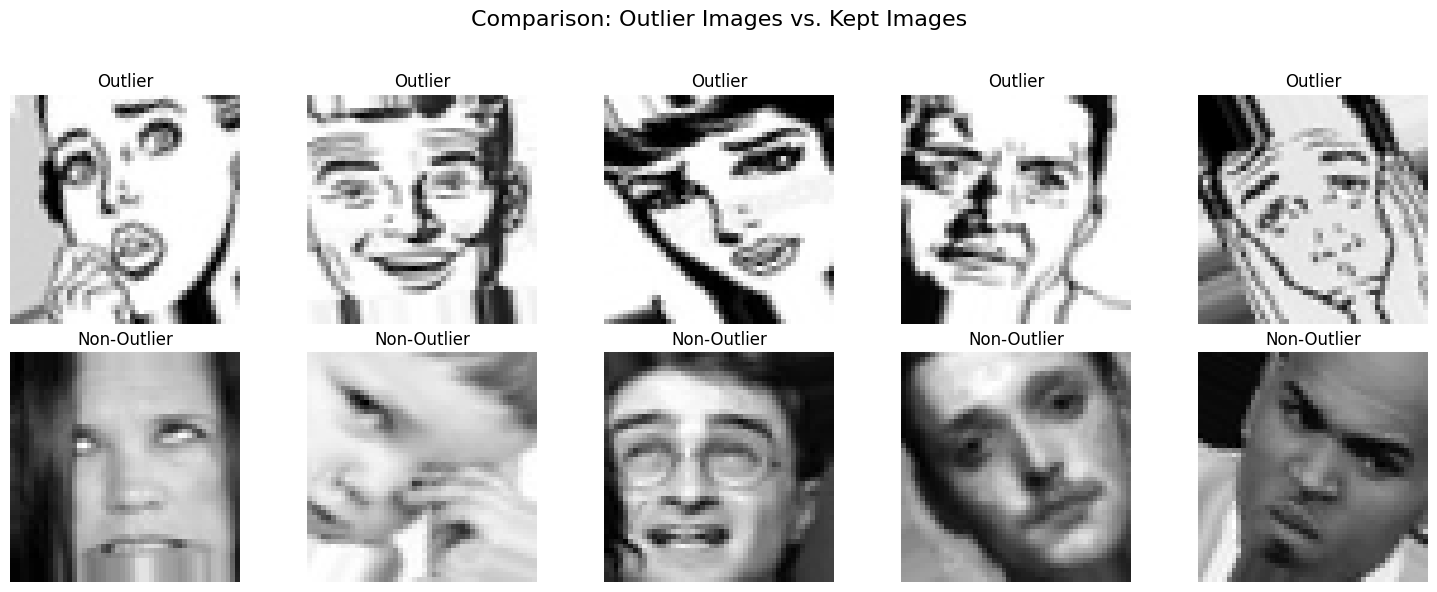

In [37]:
num_examples = 5

visualize_outliers(num_examples, traingen, batch_size, outlier_indices)

<div style="font-size: 75%; text-align: left;">
Figure 6. XXXXX

In [38]:
output_clean_train(DATA_DIR, traingen, outlier_indices)

100%|██████████| 22968/22968 [00:04<00:00, 4905.70it/s]

Copied 22508 non-outlier images to //data/clean_train


#### 2.3.5 Meaningful Insights <a class="anchor" id="meaningful-insights"></a>

<div style="font-size: 95%; text-align: left;">
Based on our data analysis, we have several meaningful insights that inform the design of a more robust facial expression classification model. These findings are organized into the following key areas:
<br>

<u>**No Missing Data**</u><br>
As verified earlier, the training, validation, and test sets contain no missing pixel values. This ensures the dataset is complete and ready for modeling without requiring imputation or data cleaning for missing values.

<u>**Class Imbalance**</u><br>
The dataset shows clear class imbalance. The disgust category is notably underrepresented (with ~300 samples), while happy is overrepresented (~5,800 samples). This imbalance can lead to biased predictions and poor generalization. To address this, we applied targeted data augmentation and computed class_weight values to rebalance the model’s learning. These techniques help ensure underrepresented emotions receive appropriate attention during training.

<u>**Watermarks**</u><br>
A small subset of images contains watermarks, which may interfere with feature extraction. We experimented with non-local means (NLM) denoising to address this issue. While NLM effectively reduced watermark visibility, it also introduced smoothing that blurred critical facial features—especially around the eyes—potentially degrading model performance. Alternative approaches, such as Gaussian denoising, were also tested but did not yield significantly better results. As a result, watermark handling remains a challenge, and we may rely more on data augmentation to improve generalization rather than aggressive denoising.

<u>**Outliers**</u><br>
To identify and remove extreme cases that denoising could not resolve (e.g., occlusions, drawn faces, low-contrast or stretched images), we trained a shallow autoencoder and used reconstruction error as a filter. Images exceeding the 98th percentile in error (about 2% of the training set, or 460 images) were flagged as outliers. These were excluded from training, reducing the set to 22,508 images. Removing these anomalous samples helps reduce noise variance, improves class-specific clarity, and promotes better generalization.

## 3. Research Question <a class="anchor" id="research-question"></a>

<div style="font-size: 95%; text-align: left;">
Now that we've established an exhaustive EDA, we present the research questions that will guide our empirical analysis. 
<br>

1. What is the best custom model architecture for classifying human facial expressions and how well does it perform compared to existing models in the literature?$^{[3]}$

2. How does the model perform for each emotion class? What are the implications of the results?

3. How do vision transformers model compare to CNN models in terms of performance for the FER-2013 dataset?

## 4. Baseline Model <a class="anchor" id="baseline-model"></a>

We wanted to run an experiment to compare two scaling methods **1)** ***standard scaling*** and **2)** ***min-max scaling*** and use the baseline model performance to make a decision.

Even though the `per_image_standardization` yields slightly better results, the training time increased, which is why we decided to move forward with the min-max scaling. Being able to quickly iterate over new architectures is more beneficial. Other experiments with data augmentation and class weights were conducted as well. They did not prove to be beneficial to the baseline model, so we removed them to make the notebook more clean. However, we expect to use these strategies for more complex models downstream.

For our baseline model, we will only normalize the pixel values of our training and validation set (more details in the next section).

### 4.1 MinMax Standardization  <a class="anchor" id="minmax-standardization"></a>

In [39]:
target_size = (48, 48)
batch_size = 32

baseline_train_datagen = image_dataset_from_directory(
    DATA_DIR + "/clean_train",
    image_size=target_size,
    batch_size=batch_size,
    label_mode="categorical",
    color_mode="grayscale",
)

baseline_val_datagen = image_dataset_from_directory(
    val_dir,
    image_size=target_size,
    batch_size=batch_size,
    label_mode="categorical",
    color_mode="grayscale",
)


def minmax_norm(x, y):
    return x / 255.0, y


train_norm = baseline_train_datagen.map(
    minmax_norm, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(buffer_size=tf.data.AUTOTUNE)

val_norm = baseline_val_datagen.map(
    minmax_norm, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 22508 files belonging to 7 classes.
Found 5741 files belonging to 7 classes.


In [40]:
# test if GPU is available
if tf.config.list_physical_devices("GPU"):
    print("GPU available")
else:
    print("No GPU available")

# set seeds for reproducibility
os.environ["PYTHONHASHSEED"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)


# plot accuracy
def plot_accuracy(history, plot_title="Model"):
    """
    Helper function to plot accuracy of a model.
    """

    plt.figure(figsize=(12, 6))

    best_val_acc = np.max(history.history["val_accuracy"])
    best_epoch = np.argmax(history.history["val_accuracy"])

    epochs = range(1, len(history.history["accuracy"]) + 1)

    plt.plot(epochs, history.history["accuracy"], label="Training Accuracy")
    plt.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy")

    plt.axvline(
        best_epoch + 1,
        color="red",
        linestyle="--",
        label=f"Best val acc: {best_val_acc:.4f}",
    )

    plt.title(f"{plot_title}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(epochs)
    plt.legend(loc="lower right")

GPU available


<div style="font-size: 95%; text-align: left;">

The baseline model will follow a very basic model architecture taken from the Lab's code. We added one regularization layer and adjusted the output layer. The loss function was adjusted as well to account for the classes in our data.

In [41]:
# very basic model
def create_baseline_model(show_summary=False):
    inputs = Input(shape=(48, 48, 1))

    x = Conv2D(64, kernel_size=(3, 3), activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(16, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(7, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    if show_summary:
        model.summary()

    return model

In [42]:
baseline_model = create_baseline_model(show_summary=True)

baseline_model_history = baseline_model.fit(
    train_norm, validation_data=val_norm, epochs=15, verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,527 (224.71 KB)

 Trainable params: 57,527 (224.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.2319 - loss: 1.8274 - val_accuracy: 0.3571 - val_loss: 1.6384
Epoch 2/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3626 - loss: 1.6329 - val_accuracy: 0.4069 - val_loss: 1.5336
Epoch 3/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4024 - loss: 1.5361 - val_accuracy: 0.4391 - val_loss: 1.4596
Epoch 4/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4338 - loss: 1.4613 - val_accuracy: 0.4658 - val_loss: 1.4005
Epoch 5/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4527 - loss: 1.4100 - val_accuracy: 0.4754 - val_loss: 1.3833
Epoch 6/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4755 - loss: 1.3650 - val_accuracy: 0.4797 - val_loss: 1.3650
Epoch 7/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4910 - loss: 1.3321 - val_accuracy: 0.5017 - val_loss: 1.3170
Epoch 8/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4994 - loss: 1.3055 - val_accuracy: 

Baseline Model with Pixel Normalization
Train Loss: 103.5617, Train Accuracy: 0.3986
Validation Loss: 118.2459, Validation Accuracy: 0.3640


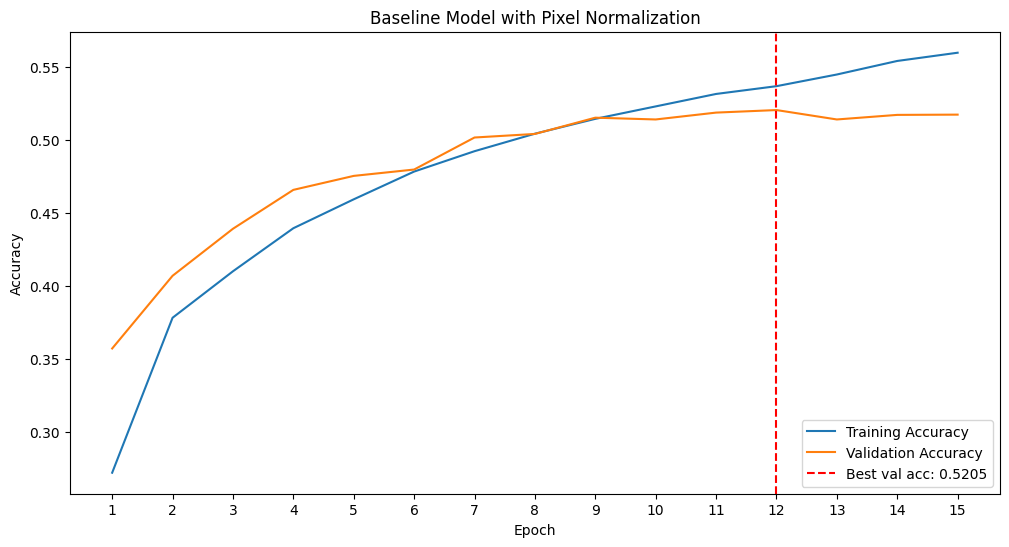

In [43]:
train_loss, train_acc = baseline_model.evaluate(baseline_train_datagen, verbose=0)
val_loss, val_acc = baseline_model.evaluate(baseline_val_datagen, verbose=0)

print("Baseline Model with Pixel Normalization")
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

plot_accuracy(baseline_model_history, "Baseline Model with Pixel Normalization")

<div style="font-size: 75%; text-align: left;">
Figure 7. XXXXX

<div style="font-size: 95%; text-align: left;">
While these initial results provide a rough sense of performance, they are not sufficient to fully evaluate the model. The baseline serves primarily to confirm two things: (1) the model and data generators are functioning correctly, and (2) without any preprocessing, we achieve a validation accuracy of approximately 52% after 14 epochs. However, the fact that training accuracy begins to decline after just 5 epochs without a corresponding rise in validation accuracy may indicate issues with the model architecture or implementation. Fortunately, this is only a baseline, intended as a starting point for further refinement.

### 4.2 Improved Baseline: UNet  <a class="anchor" id="unet"></a>

During preprocessing, pixel values are divided by 255 to scale them into the [0,1] range. Labels were processed using label_mode="categorical" to convert them into one-hot encoded vectors, which aligns with the loss function = "categorical_crossentropy". 

The U-Net model architecture includes an encoder with three convolutional blocks. Each block contains 64, 128, 256 filters respectfully. Each blocks uses batch normalization, ReLU activation, dropout, and max pooling for downsampling. The decoder applied upsampling and skip connections. Each skip connection uses channel-wise attention mechanisms. Multi-level features from different depths of the network were aggregated using global average pooling and concatenated to get feature representation. It then passes through dense layer with 256 nodes, ReLU activation, dropout (rate = 0.5), and a final softmax layer to predict one of seven emotions for classification tasks.

The total number of trainable parameters in the U-Net model was ??? get info from model.summary(). Training was performed using the Adam optimizer with a learning rate of 0.001, a batch size of 64, and 50 epochs. L2 regularization is applied to all convolutional and dense layers to reduce overfitting.

Accuracy was monitored during training, and we plot the training/validation loss and accuracy curves over epochs. Further evaluation is applied using a classification report (precision, recall, F1-score per class), confusion matrices, and 

<div style="font-size: 95%; text-align: left;">

***Sidenote:*** *We fine-tuned both ResNet50 and VGG16 models, but the results were not promising. These models proved too complex for our task and did not outperform the baseline—at least at this stage. For this reason, we decided to build our own architecture, guided by existing literature on facial recognition.*

We chose to try U-Net because it offers a balanced trade-off between complexity and performance for emotion recognition, combining multi-scale feature integration with natural attention mechanisms through its skip connections. The encoder-decoder structure captures facial features at different resolutions while keeping the model lighter than VGG16, yet more sophisticated than our baseline CNN—making it well-suited for the size and characteristics of the FER-2013 dataset. Two experiments were conducted on u-net to determine the best scaling method. Standard scaling and min-max scaling were both tested. There was no difference in the results, we will use min-max scaling for its simplicity. We also tried to refactor the model to use depthwise separable convolutions, which are more efficient than standard convolutions. Although the change reduced runtime, it can at the cost of 3% accuracy. 

In [44]:
def create_unet_model():
    # input layer - 48x48 grayscale
    inputs = Input(shape=(48, 48, 1))

    # --- encoder path ---

    # first block - level 1
    x1 = Conv2D(64, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(1e-4))(
        inputs
    )
    x1 = BatchNormalization()(x1)
    x1 = Activation("relu")(x1)
    x1 = Conv2D(64, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(1e-4))(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation("relu")(x1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(x1)
    pool1 = SpatialDropout2D(0.1)(pool1)

    # second block - level 2
    x2 = Conv2D(128, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(1e-4))(
        pool1
    )
    x2 = BatchNormalization()(x2)
    x2 = Activation("relu")(x2)
    x2 = Conv2D(128, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(1e-4))(
        x2
    )
    x2 = BatchNormalization()(x2)
    x2 = Activation("relu")(x2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(x2)
    pool2 = SpatialDropout2D(0.2)(pool2)

    # third block - bottleneck
    x3 = Conv2D(256, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(1e-4))(
        pool2
    )
    x3 = BatchNormalization()(x3)
    x3 = Activation("relu")(x3)
    x3 = Conv2D(256, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(1e-4))(
        x3
    )
    x3 = BatchNormalization()(x3)
    x3 = Activation("relu")(x3)

    # --- decoder path with attention ---

    # level 2 upsampling
    up2 = UpSampling2D(size=(2, 2))(x3)
    up2 = Conv2D(128, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(1e-4))(
        up2
    )
    up2 = BatchNormalization()(up2)
    up2 = Activation("relu")(up2)

    # attention for level 2
    attn2 = Conv2D(128, kernel_size=(1, 1), padding="same")(x2)
    attn2 = BatchNormalization()(attn2)
    attn2 = Activation("sigmoid")(attn2)
    attended_x2 = Multiply()([x2, attn2])

    # combine features
    merge2 = Concatenate()([up2, attended_x2])
    merge2 = Conv2D(
        128, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(1e-4)
    )(merge2)
    merge2 = BatchNormalization()(merge2)
    merge2 = Activation("relu")(merge2)

    # level 1 upsampling
    up1 = UpSampling2D(size=(2, 2))(merge2)
    up1 = Conv2D(64, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(1e-4))(
        up1
    )
    up1 = BatchNormalization()(up1)
    up1 = Activation("relu")(up1)

    # attention for level 1
    attn1 = Conv2D(64, kernel_size=(1, 1), padding="same")(x1)
    attn1 = BatchNormalization()(attn1)
    attn1 = Activation("sigmoid")(attn1)
    attended_x1 = Multiply()([x1, attn1])

    # combine features
    merge1 = Concatenate()([up1, attended_x1])
    merge1 = Conv2D(
        64, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(1e-4)
    )(merge1)
    merge1 = BatchNormalization()(merge1)
    merge1 = Activation("relu")(merge1)

    # --- feature extraction ---

    # multi-level features
    feat_lvl3 = GlobalAveragePooling2D()(x3)
    feat_lvl2 = GlobalAveragePooling2D()(merge2)
    feat_lvl1 = GlobalAveragePooling2D()(merge1)
    combined_features = Concatenate()([feat_lvl1, feat_lvl2, feat_lvl3])

    # classification head
    x = Dense(256, kernel_regularizer=l2(1e-4))(combined_features)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    # output for 7 emotions
    outputs = Dense(7, activation="softmax")(x)

    # create model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# training takes a lot to train, beware!
if not os.path.exists("models/unet_attention_fer_model.keras"):

    unet_model = create_unet_model()

    callbacks = [
        EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5),
        ModelCheckpoint(
            "models/unet_attention_fer_model.keras",
            monitor="val_accuracy",
            save_best_only=True,
        ),
    ]

    unet_history = unet_model.fit(
        train_norm,
        validation_data=val_norm,
        epochs=50,
        batch_size=64,
        callbacks=callbacks,
    )
    with open("model_history/unet_history.pkl", "wb") as f:
        pickle.dump(unet_history, f)
else:
    print("Model file already exists. Skipping training.")
    # Load the existing model if needed
    unet_model = tf.keras.models.load_model("models/unet_attention_fer_model.keras")

    with open("model_history/unet_history.pkl", "rb") as f:
        unet_history = pickle.load(f)

Model file already exists. Skipping training.


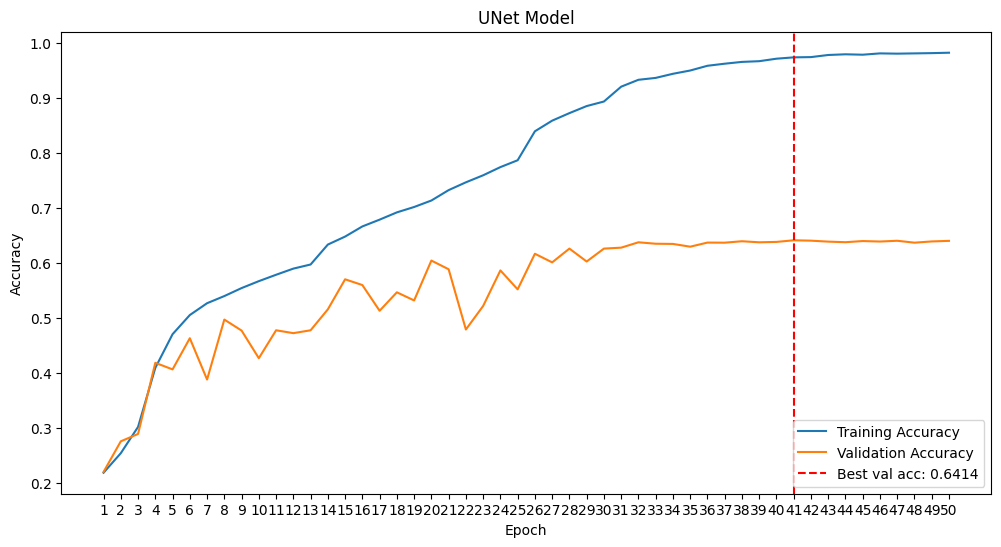

In [45]:
plot_accuracy(unet_history, "UNet Model")

<div style="font-size: 75%; text-align: left;">
Figure 10. XXXXX

<div style="font-size: 95%; text-align: left;">
There is definitely an improvement over our original baseline model. This updated model will serve as our new baseline moving forward, as we are confident there is still room for further improvement.

### 4.3 Modeling Summary <a class="anchor" id="modeling-summary"></a>

In the above experiment, we implemented two preprocessing methods: rescaling by dividing pixel values by 255 to normalize data within the [0,1] range, and per-image standardization to normalize each image individually, addressing variations in lighting and contrast. Although performance improved with per-image standardization, the gain was not significant enough to justify the added complexity and increased training time. As a result, we shifted to a different approach—building a more complex architecture and training it with augmented data.

Our U-Net architecture significantly outperformed the baseline CNN, achieving 64% accuracy compared to 52%. This improvement validates our strategy of using a more sophisticated architecture with built-in attention mechanisms via skip connections, which help the model focus on emotion-relevant facial features. U-Net strikes a strong balance between complexity and efficiency, capturing multi-scale information while remaining computationally feasible for the size of the FER-2013 dataset.

Looking ahead, we see several promising avenues for further improving model performance. These include experimenting with ensemble methods that combine multiple architectures, implementing cross-validation to better handle FER-2013’s class imbalance, exploring transfer learning with pre-trained facial recognition models, and investigating more advanced attention mechanisms such as transformers. Hyperparameter tuning may also yield additional performance gains.

### 4.4 Baseline Models Evaluation  <a class="anchor" id="baseline-models-evaluation"></a>

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
unet_model = tf.keras.models.load_model("models/unet_attention_fer_model.keras")

with open("model_history/unet_history.pkl", "rb") as f:
    unet_history = pickle.load(f)

In [48]:
# create a functino to plot confusion matrix
def plot_conf_matrix(cm, title, class_labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    plt.title(title)
    plt.xlabel("Predction")
    plt.ylabel("True")
    plt.show()

In [49]:
# pass data for model evaluation
# classfication_report will return metrics : precision recall  f1-score   support
# confusion matrix return true positive, true negative, false positive, false negative


def evaluate_model(model, dataset, model_name="model"):
    y_true = []
    y_pred = []

    for x_batch, y_batch in dataset:
        preds = model.predict(x_batch, verbose=0)
        y_true.extend(np.argmax(y_batch.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    print(classification_report(y_true, y_pred, target_names=class_labels.values()))

    print(f"{model_name} Confusion matrix")
    cm = confusion_matrix(y_true, y_pred)
    return y_true, y_pred, cm

2025-04-28 19:34:13.905782: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

       angry       0.42      0.44      0.43       799
     disgust       0.67      0.05      0.09        87
        fear       0.35      0.25      0.29       819
       happy       0.72      0.75      0.74      1443
     neutral       0.45      0.48      0.47       993
         sad       0.37      0.46      0.41       966
    surprise       0.71      0.64      0.67       634

    accuracy                           0.52      5741
   macro avg       0.53      0.44      0.44      5741
weighted avg       0.52      0.52      0.51      5741

Simple CNN Confusion matrix


2025-04-28 19:34:41.204179: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

       angry       0.54      0.58      0.56       799
     disgust       0.76      0.51      0.61        87
        fear       0.54      0.36      0.43       819
       happy       0.84      0.84      0.84      1443
     neutral       0.57      0.64      0.60       993
         sad       0.51      0.55      0.53       966
    surprise       0.74      0.78      0.76       634

    accuracy                           0.64      5741
   macro avg       0.64      0.61      0.62      5741
weighted avg       0.64      0.64      0.64      5741

U-Net Confusion matrix


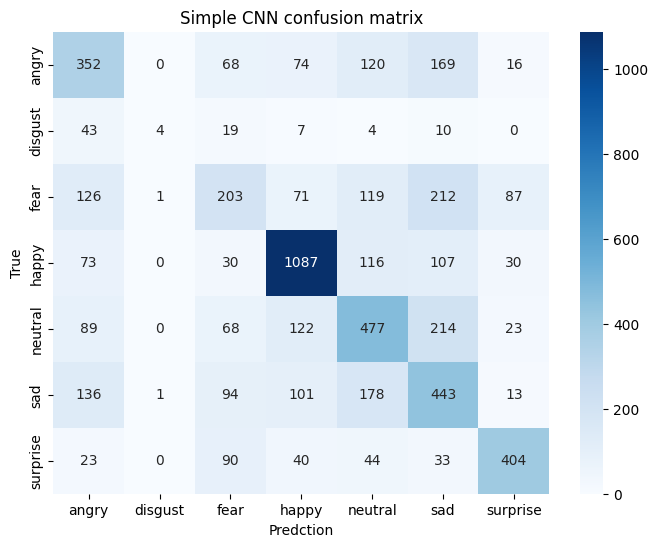

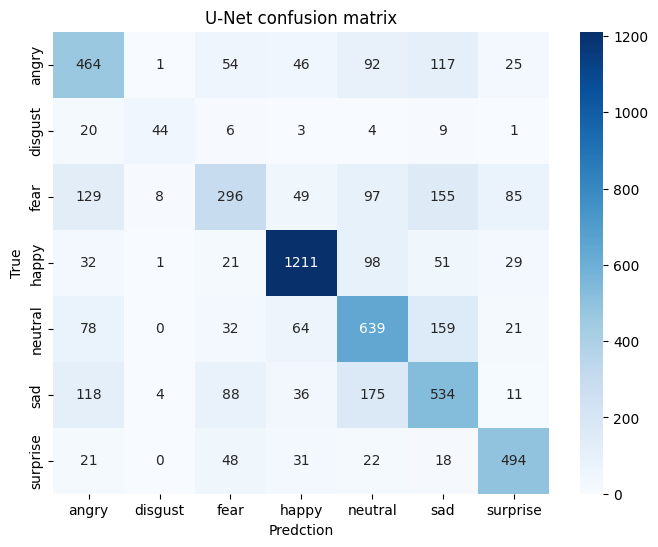

In [50]:
y_true_base, y_pred_base, cm_base = evaluate_model(
    baseline_model, val_norm, "Simple CNN"
)
y_true_unet, y_pred_unet, cm_unet = evaluate_model(unet_model, val_norm, "U-Net")

plot_conf_matrix(cm_base, "Simple CNN confusion matrix", class_labels.values())
plot_conf_matrix(cm_unet, "U-Net confusion matrix", class_labels.values())

For our first baseline, we used a simple 2D convolutional neural network with three convolutional layers. It’s a simple architectural, easy to understand. However, the accuracy is not ideal, only achieving 53% overall accuracy. Happy and surprise emotions are predicted well with F1 score of 68%. However disgust and fear performs poorly, where disgust shows 0 precision and 0 recall, which indicates model cannot recognize this emotion. This aligns with our initial anticipation as a simple CNN might not be able to capture complex feature representations. 

To overcome the limitation, we moved on to U_net model. Based on the classification report and confusion matrix, The U_net baseline model achieved an overall satisfiying F1 score of 76%. The model predicts very well in 'happy', followed by good performance on 'surprise' and 'sad', while struggles to predict 'disgust' and 'fear'. 

Among happy emotion, 1249/1443 correctly classified. High precision (0.88) and recall (0.87), F1-score (0.87). This strong performance may be attributed to the distinctiveness of happy facial expressions and the fact that the dataset had the most samples for this emotion. Surprise also performs very well with 503/634 correctly classified with F1-score 0.81. Disgust is the weakest class with Recall(0.51), indicating only half of the disgust images were correctly found. The F1-score (0.62). This can be explained by the fact that disgust faces are hard to distinguish from angry or fearful emotions. Additionally, the dataset contained very few disgust samples — only 87 images compared to 1443 happy images — which could contributed to the lower performance. Fear is also lower performance. Recall 0.58, the model struggles to detect fear emotions. 

The U_net model significantly outperformed the simple cnn model cross all emotions. It indicates that ophisticated architectures are needed for achieving reliable facial emotion recognition.The U_Net model is chosen for our baseline model.


## 5. Final Model  <a class="anchor" id="final-model"></a>

### 5.1 Proposed Pipeline  <a class="anchor" id="proposed-pipeline"></a>

#### 5.1.3 Preprocessing Steps

**Preprocessing**
- Use the existing denoising and pixel normalization preprocessing already applied to the dataset (Section 4.1).


**Handle Class Imbalance**
- Our EDA revealed that the FER-2013 dataset is significantly imbalanced across classes. In particular, emotions like "disgust" and "surprise" had much fewer samples compared to "happy" or "neutral."
- To address this imbalance, we decided to apply **class weighting** during model training. Specifically, we calculated weights inversely proportional to the frequency of each class in the training set. These weights were passed into the loss function, allowing the model to penalize mistakes on minority classes more heavily.
- This strategy was chosen over oversampling methods like SMOTE, since FER-2013 images are highly sensitive to local structure and naive oversampling often leads to overfitting or unrealistic images.
- In the final model (including ViT and U-Net variants), we will continue using these calculated class weights during training to ensure balanced learning across all emotion categories.


**Train/Validation/Test Split**
We modified the original FER-2013 directory structure to create a new validation set directly from the training data.


Specifically:
- We started with the provided "Training" split.
- We randomly selected 20% of the training images (stratified by class) and moved them into a newly created "Validation" folder.
- This left us with:
 - **22,968 images** in the final **Training** set
 - **5,741 images** in the newly created **Validation** set
- We left the original "Test" set **untouched** with **7,178 images**.


By creating the validation set directly from the training set, we ensured that validation and training images came from the same original distribution. This approach allowed us to use the official Test set exclusively for the final model evaluation without any contamination from model development.


Importantly:
- The split was random but stratified to preserve class balance.
- The Test set remained strictly a holdout set, used only once after all training and tuning were complete.


Summary:
| Dataset          | Source                         | Number of Images | Purpose                                  |
|------------------|---------------------------------|------------------|------------------------------------------|
| Training Set     | 80% of original "Train"   | 22,968            | Model fitting                           |
| Validation Set   | 20% of original "Train"   | 5,741             | Hyperparameter tuning, early stopping   |
| Test Set         | Original "Test"           | 7,178             | Final unbiased model evaluation         |


**Outlier Detection and Removal**
To further improve data quality, we trained a shallow autoencoder on the training set and used reconstruction error as a filter to identify extreme outliers that denoising could not resolve, such as occluded, drawn, or severely distorted faces. Images exceeding the 98th percentile in reconstruction error (approximately 460 samples, or about 2% of the training set) were flagged and removed. After this outlier removal step, the training set was reduced from 22,968 to 22,508 images. Excluding these anomalous samples helped reduce noise variance in the data, improved class-specific clarity, and promoted better model generalization during training.


**Model Architecture**
- Improve u-net: Augment the data & update the architecture
- Test out Vision Transformer
- Transfer learning (EfficientNet)



#### 5.1.2 Enhanced UNet

We introduced two main enhancements to the baseline U-Net: squeeze-excite blocks and class weighting. Squeeze-excite blocks work by helping the model focus more on the most important features, adjusting the strength of each channel based on how useful it is for the task. Since recognizing emotions often depends on picking up subtle cues in facial expressions, we expected this to help the model be more selective and accurate. We also added class weighting to deal with the natural imbalance in the FER2013 dataset, making sure that less common emotions like “disgust” or “surprise” weren’t overlooked during training. Together, these changes were aimed at helping the model better capture important details and perform more consistently across all classes.

In practice, though, the enhanced U-Net didn’t perform as well, reaching 64% accuracy compared to 76% for the baseline. One possible reason is that the squeeze-excite blocks may have put too much emphasis on certain features while downplaying others that were still important for distinguishing between similar emotions. With a dataset as noisy and low-resolution as FER2013, this extra complexity might have made it harder for the model to generalize. Class weighting could have also shifted the learning process too much toward minority classes, disrupting the model’s overall balance. While the enhancements were promising in theory, they ended up making it harder for the model to handle the messy real-world data in this case.

In [51]:
def create_enhanced_unet_model():

    # Slightly increased regularization
    reg_strength = 2e-4

    # input layer - 48x48 grayscale
    inputs = Input(shape=(48, 48, 1))

    # --- encoder path with residual connections ---

    # first block - level 1
    conv1 = Conv2D(
        64, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(reg_strength)
    )(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation("relu")(conv1)
    conv1_res = conv1

    conv1 = Conv2D(
        64, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(reg_strength)
    )(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation("relu")(conv1)

    # residual connection
    conv1 = Add()([conv1, conv1_res])

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = SpatialDropout2D(0.15)(pool1)  # Slightly increased dropout

    # second block - level 2
    conv2 = Conv2D(
        128, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(reg_strength)
    )(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    conv2_res = conv2

    conv2 = Conv2D(
        128, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(reg_strength)
    )(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(conv2)

    # residual connection
    conv2 = Add()([conv2, conv2_res])

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = SpatialDropout2D(0.25)(pool2)  # Slightly increased dropout

    # third block - bottleneck with dilated convolutions
    conv3 = Conv2D(
        256,
        kernel_size=(3, 3),
        padding="same",
        dilation_rate=(2, 2),
        kernel_regularizer=l2(reg_strength),
    )(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation("relu")(conv3)
    conv3_res = conv3

    conv3 = Conv2D(
        256, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(reg_strength)
    )(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation("relu")(conv3)

    # residual connection
    conv3 = Add()([conv3, conv3_res])

    # --- Squeeze-Excite attention at bottleneck ---
    se_channels = 256
    se_global_pool = GlobalAveragePooling2D()(conv3)
    se_dense_1 = Dense(se_channels // 16, activation="relu")(se_global_pool)
    se_dense_2 = Dense(se_channels, activation="sigmoid")(se_dense_1)
    se_reshape = Reshape((1, 1, se_channels))(se_dense_2)
    conv3 = Multiply()([conv3, se_reshape])

    # --- decoder path with spatial attention ---

    # level 2 upsampling
    up2 = UpSampling2D(size=(2, 2))(conv3)
    up2 = Conv2D(
        128, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(reg_strength)
    )(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation("relu")(up2)

    # simplified attention for conv2
    avg_pool_2 = Conv2D(1, kernel_size=1)(Conv2D(128, kernel_size=1)(conv2))
    max_pool_2 = Conv2D(1, kernel_size=1)(Conv2D(128, kernel_size=1)(conv2))
    attn2 = Concatenate()([avg_pool_2, max_pool_2])
    attn2 = Conv2D(1, kernel_size=(7, 7), padding="same", activation="sigmoid")(attn2)
    attended_x2 = Multiply()([conv2, attn2])

    # combine upsampled features with attended encoder features
    merge2 = Concatenate()([up2, attended_x2])
    conv2_up = Conv2D(
        128, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(reg_strength)
    )(merge2)
    conv2_up = BatchNormalization()(conv2_up)
    conv2_up = Activation("relu")(conv2_up)

    # level 1 upsampling
    up1 = UpSampling2D(size=(2, 2))(conv2_up)
    up1 = Conv2D(
        64, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(reg_strength)
    )(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation("relu")(up1)

    # simplified attention for conv1
    avg_pool_1 = Conv2D(1, kernel_size=1)(Conv2D(64, kernel_size=1)(conv1))
    max_pool_1 = Conv2D(1, kernel_size=1)(Conv2D(64, kernel_size=1)(conv1))
    attn1 = Concatenate()([avg_pool_1, max_pool_1])
    attn1 = Conv2D(1, kernel_size=(7, 7), padding="same", activation="sigmoid")(attn1)
    attended_x1 = Multiply()([conv1, attn1])

    # combine upsampled features with attended encoder features
    merge1 = Concatenate()([up1, attended_x1])
    conv1_up = Conv2D(
        64, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(reg_strength)
    )(merge1)
    conv1_up = BatchNormalization()(conv1_up)
    conv1_up = Activation("relu")(conv1_up)

    # --- feature fusion ---

    # extract features from multiple levels
    feat_lvl3 = GlobalAveragePooling2D()(conv3)
    feat_lvl2 = GlobalAveragePooling2D()(conv2_up)
    feat_lvl1 = GlobalAveragePooling2D()(conv1_up)

    # extract max features too
    max_feat_lvl3 = GlobalMaxPooling2D()(conv3)
    max_feat_lvl2 = GlobalMaxPooling2D()(conv2_up)
    max_feat_lvl1 = GlobalMaxPooling2D()(conv1_up)

    # concatenate avg and max features
    feat_lvl3 = Concatenate()([feat_lvl3, max_feat_lvl3])
    feat_lvl2 = Concatenate()([feat_lvl2, max_feat_lvl2])
    feat_lvl1 = Concatenate()([feat_lvl1, max_feat_lvl1])

    # simply concatenate all features
    combined_features = Concatenate()([feat_lvl3, feat_lvl2, feat_lvl1])
    combined_features = Dropout(0.3)(
        combined_features
    )  # Added dropout before classification

    # --- classification head with improved regularization ---
    x = Dense(256, kernel_regularizer=l2(reg_strength))(combined_features)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.6)(x)  # Increased dropout

    x = Dense(128, kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)  # Increased dropout

    # output for 7 emotions
    outputs = Dense(7, activation="softmax")(x)

    # create model
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.15),
        metrics=["accuracy", tf.keras.metrics.F1Score(average="weighted")],
    )

    return model


# train with improved model
if not os.path.exists("models/enhanced_unet_model.keras"):
    # create enhanced model
    enhanced_model = create_enhanced_unet_model()

    # define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy", patience=15, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.6, patience=5, min_lr=1e-5, verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            "models/enhanced_unet_model.keras",
            monitor="val_accuracy",
            save_best_only=True,
        ),
        # learning rate warmup schedule
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch, lr: min(2e-4, lr + 2e-4 / 5) if epoch < 5 else lr
        ),
    ]

    enhanced_history = enhanced_model.fit(
        train_norm,
        validation_data=val_norm,
        epochs=100,
        class_weight=class_weights_dict,  # using class weights
        callbacks=callbacks,
    )

    with open("model_history/enhanced_unet_history.pkl", "wb") as f:
        pickle.dump(enhanced_history, f)
else:
    print("Enhanced model file already exists. Skipping training.")
    enhanced_model = tf.keras.models.load_model("models/enhanced_unet_model.keras")

    try:
        with open("model_history/enhanced_unet_history.pkl", "rb") as f:
            enhanced_history = pickle.load(f)
    except:
        print("History file not found.")

Enhanced model file already exists. Skipping training.


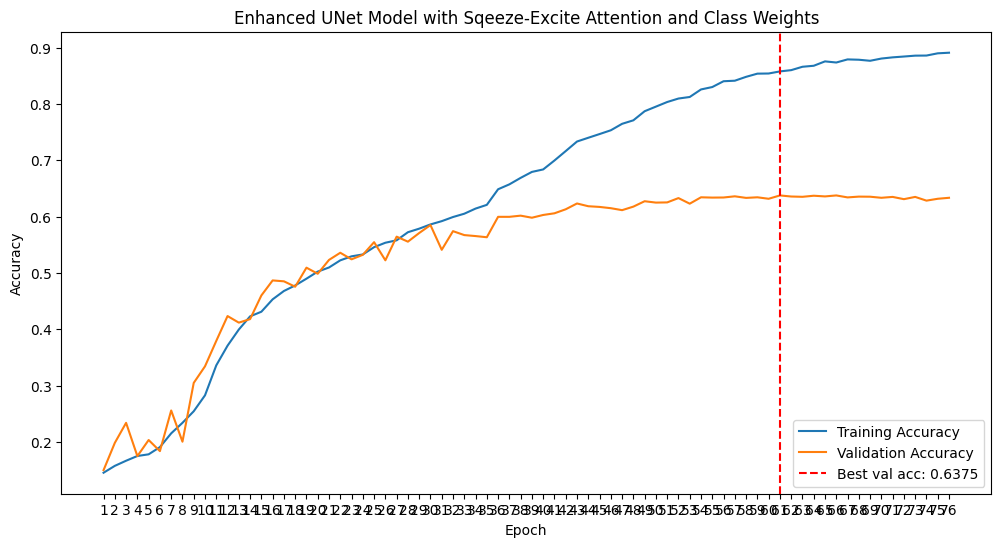

In [52]:
plot_accuracy(
    enhanced_history,
    "Enhanced UNet Model with Sqeeze-Excite Attention and Class Weights",
)

2025-04-28 19:35:15.447765: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_672', 8 bytes spill stores, 8 bytes spill loads



              precision    recall  f1-score   support

       angry       0.89      0.87      0.88       799
     disgust       0.95      0.94      0.95        87
        fear       0.87      0.80      0.83       819
       happy       0.96      0.94      0.95      1443
     neutral       0.83      0.89      0.86       993
         sad       0.81      0.83      0.82       966
    surprise       0.93      0.93      0.93       634

    accuracy                           0.88      5741
   macro avg       0.89      0.89      0.89      5741
weighted avg       0.88      0.88      0.88      5741

Enhanced U-Net Confusion matrix


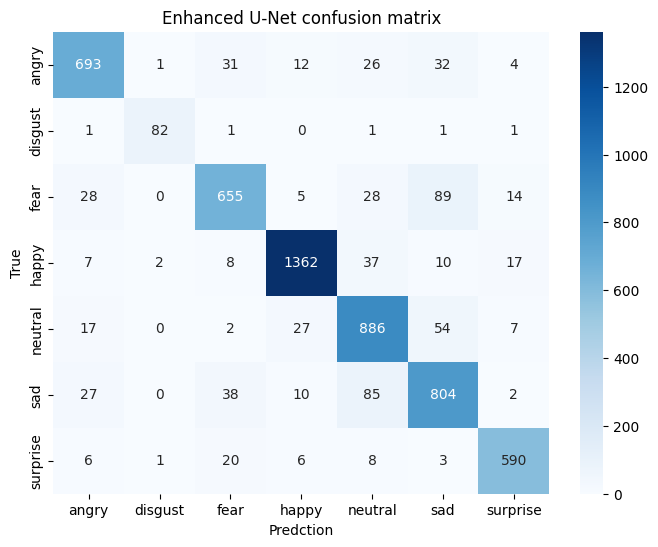

In [53]:
y_true_unet_enh, y_pred_unet_enh, cm_unet_enh = evaluate_model(
    enhanced_model, val_norm, "Enhanced U-Net"
)

plot_conf_matrix(cm_unet_enh, "Enhanced U-Net confusion matrix", class_labels.values())

Overall, the baseline U-Net showed stronger and more balanced F1-scores across all classes compared to the enhanced version, which struggled especially with harder emotions like “fear” and “sad.” This suggests that the simpler baseline was better at handling the noise and variability of FER2013 without overcomplicating feature selection. Given these results, we’ll move on from U-Net-based models and explore different architectures that might be better suited for this kind of emotion recognition task.

### 5.2 Assumptions, Parameters and Tuning  <a class="anchor" id="assumptions-parameters-tuning"></a>

**Candidate Models**
- Baseline:
   - Loss Function: Categorical Crossentropy
   - Optimizer: Adam
   - Learning Rate: 0.001
- UNet Baseline:
   - Loss Function: Categorical Crossentropy
   - Optimizer: Adam
   - Learning Rate: 0.001
- UNet Improved:
   - Loss Function: Categorical Crossentropy
   - Optimizer: Adam
   - Learning Rate: 0.001
   - Early stopping based on validation loss to prevent overfitting.
- Visual Transformer
   - **Input Image Size**: Resize FER-2013 images from 48×48 to 224×224 pixels to match ViT’s input requirement.
   - **Color Channels**: Convert grayscale images to 3-channel inputs by duplicating the single channel.
   - **Pretrained Backbone**: Fine-tune a lightweight pretrained Vision Transformer model (ViT-Tiny or DeiT-Tiny).
   - **Training Strategy**: Perform fine-tuning rather than training from scratch, due to the relatively small dataset size.
   - **Overfitting Prevention**: Apply the same data augmentation and incorporate dropout between 0.1–0.2.
   - **Optimizer**: Use AdamW optimizer, which is well-suited for fine-tuning Transformer architectures.
   - **Learning Rate**: Set an initial learning rate of 1e-4 for stable fine-tuning.
   - **Batch Size**: Use a batch size between 32 and 64 (Adjust based on the performance).
   - **Early Stopping**: Implement early stopping with a patience of 5–10 epochs based on validation loss to prevent overfitting.
- EfficientNet:
   - Apply transfer learning to EfficientNetB0, since it works better with lower resolution images.
   - We will unfreeze 40% of the top-most layers (last layers) and add a custom head.
   - Loss Function: Sparse Categorical Crossentropy.
   - Batch size will range from 32 to 256.
   - Optimizer: Adam or SGD with Nesterov momentum.
   - Learning Rate: 0.0005
       - Small learning rate to prevent drastic changes in weights.
   - Data Augmentation: rotation, zoom, contrast, brightness, and horizontal flip.
       - If time, more advanced augmentation techniques like CutMix or MixUp with label smoothing.
   - Early stopping based on validation loss to prevent overfitting.
   - Regularization: weight decay, stochastic depth.




**Evaluation**
- Evaluate model performance using:
 - Accuracy
 - Precision, Recall, F1 Score
 - Confusion Matrix
 - GradCAM visualization

## 6. Visualizations  <a class="anchor" id="visualizations"></a>

<div style="font-size: 95%; text-align: left;">

All visualizations above are clean, well-labeled, and designed to communicate insights clearly and effectively. Each plot includes appropriate titles, axis labels, and legends, ensuring they are ready for both presentations and reports. Below, we present a series of additional visualizations that go beyond traditional EDA to assess and interpret the behavior of our trained baseline models. These visualizations help us better understand how the models make decisions, what features they rely on, and where they focus their attention.

### 6.1 GradCAM  <a class="anchor" id="gradcam"></a>

<div style="font-size: 95%; text-align: left;">

To better understand how our models make predictions, we used Grad-CAM to generate class activation heatmaps for both the baseline_model and the baseline_std_model. These visualizations highlight the regions of each image that the model focuses on when making classification decisions.

**Key Findings:**

<u>*Baseline Model*</u><br> 
The Grad-CAM visualizations for this model were often diffuse and unfocused, occasionally highlighting background regions or unrelated areas of the face. This suggests that the baseline model had not learned strong, localized features for the task and may have been relying on more general image patterns.

<u>*Baseline Model with Per-Image Standardization*</u><br>
The Grad-CAM outputs for this model were more concentrated around core facial features—particularly the head, nose, and mouth. This tighter focus indicates that the model has learned to attend to more relevant and discriminative regions, which aligns with its improved performance metrics.

Found 22508 images belonging to 7 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


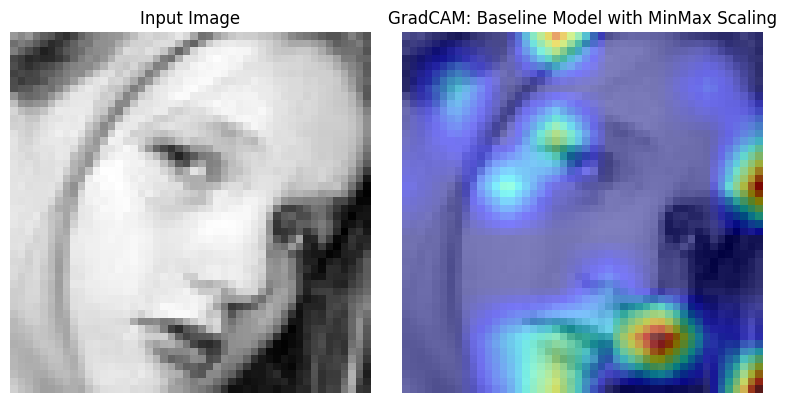

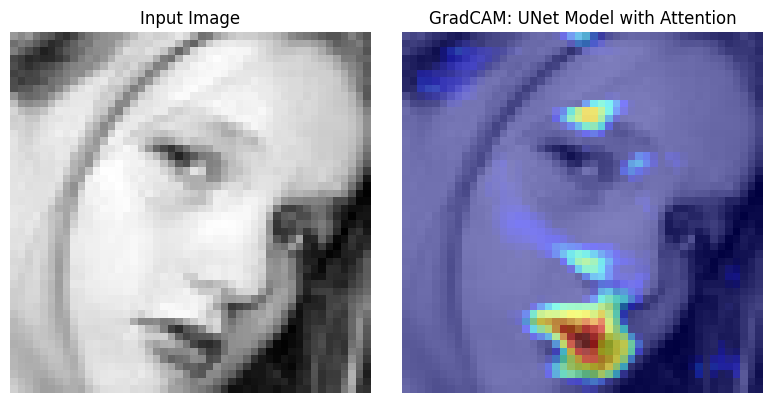

In [54]:
replace2linear = ReplaceToLinear()


def generate_gradcam(model, img, class_index):
    gradcam = Gradcam(model, model_modifier=replace2linear, clone=True)
    score = CategoricalScore([class_index])
    # This is equivalent to the above use of CategoricalScore
    # score = lambda outputs: outputs[:, class_index]
    gradcam_results = gradcam(score, img)
    return gradcam_results


def show_gradcam(model, img_array, true_class_idx, title):
    cam_result = generate_gradcam(model, img_array, true_class_idx)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img_array[0].squeeze(), cmap="gray")
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    ax[1].imshow(img_array[0].squeeze(), cmap="gray")
    ax[1].imshow(cam_result[0], cmap="jet", alpha=0.5)
    ax[1].set_title(f"GradCAM: {title}")
    ax[1].axis("off")
    plt.tight_layout()
    plt.show()


# We'll pick one image and generate GradCAM for both baseline models!
cleaned_train_gen = val_test_datagen.flow_from_directory(
    DATA_DIR + "/clean_train",
    target_size=(48, 48),
    batch_size=32,
    color_mode="grayscale",
    class_mode="categorical",
    shuffle=True,
)
sample_batch, labels = next(cleaned_train_gen)
sample_img = sample_batch[0:1]
pred_class = np.argmax(baseline_model.predict(sample_img))

show_gradcam(
    baseline_model,
    sample_img,
    pred_class,
    title="Baseline Model with MinMax Scaling",
)
show_gradcam(
    unet_model,
    sample_img,
    pred_class,
    title="UNet Model with Attention",
)

## Sources  <a class="anchor" id="sources"></a>

Wikipedia contributors. (2025, January 24). Non-local means. Wikipedia. https://en.wikipedia.org/wiki/Non-local_means

OpenCV: Denoising. (n.d.). https://docs.opencv.org/3.4/d1/d79/group__photo__denoise.html#ga03aa4189fc3e31dafd638d90de335617

Papers with Code - FER2013 Benchmark (Facial Expression Recognition (FER)). (n.d.). https://paperswithcode.com/sota/facial-expression-recognition-on-fer2013

## Appendix  <a class="anchor" id="appendix"></a>

### Mathematical Formulae  

#### Non-Local Means Denoising  
The NLM algorithm is defined as the following transformation. Let $u(p)$ be the transformed pixel value at position $p$ in the image. $C(p)$ is a normalizing constant and $\Omega$ is the set of pixels in the image. $v(q)$ is the untransformed pixel.

$$
u(p) = \frac{1}{C(p)} \sum_{q \in \Omega} v(q) \cdot w(p,q) dq
$$

The weight function $w(p,q)$ is defined as follows:

$$
w(p,q) = exp(- \frac{|B(q) - B(p)|^2}{h^2}).
$$

$h$ is the parameter we pass into the NLM function. It controls the strength of the denoising. A larger value of $h$ means more smoothing and less detail. $B(p)$ is a patch of pixels around the pixel p. The size of the patch is defined by the parameter `templateWindowSize`. $B(q)$ is a patch of pixels around the pixel q. The size of the patch is defined by the parameter `searchWindowSize`. The weight measures how similar the patches $B(p)$ and $B(q)$ are. The weight will be larger if the patches are more similar.

#### GradCAM Math

GradCAM is a technique that uses the gradients of the target class with respect to the feature maps of the last convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the class. It is preferred over CAM because it is agnostic to the architecture of the model and can be applied to any CNN-based model. The algorithm is as follows:


**Step 1**

Get the gradient of the class score with respect to the feature maps $\frac{\partial y_c}{\partial A_k}$. This measures how a class score changes with respect to a change in the feature map. We denote $k$ as the index for a given feature map.

**Step 2**

We apply global average pooling to the map of gradients

$$
\alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y_c}{\partial A_k^{ij}}
$$

The $\alpha_k^c$ are the weights for each feature map $k$. The indices $i$ and $j$ are the spatial dimensions of the feature map. This measures how an activation in the feature map affects the class score.

**Step 3**

Perform weighted sum of feature maps using these weights

$$
g_c = \sum_k \alpha_k^c A_k
$$


**Step 4**

ReLU the result

$$
g_c^* = ReLU(g_c)
$$

This means we apply the activation function to each pixel in the gradCAM map.

**Step 5**

Upsample the gradCAM map to match the dimensions of the input image.